# Atomic elements of the project

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

In [2]:
from scipy.stats import bootstrap

## 1. Empirical moment generating functions

In [15]:
N = 100
data = np.random.randn(N)

outs = []
ts = np.linspace(-2, 2)
for t in ts:
    outs.append( np.exp(t*data).mean())

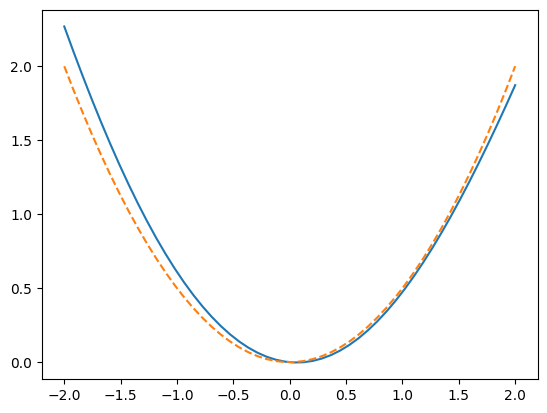

In [17]:
plt.plot(ts, np.log(outs))
plt.plot(ts, ts**2 / 2, '--')

Ok, nice. Even this small data set is sufficient to achieve a pretty good approximation. That's good if our input data is limited.

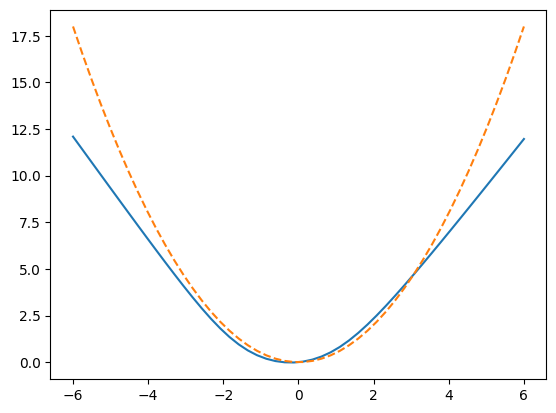

In [19]:
N = 100
data = np.random.randn(N)

outs = []
ts = np.linspace(-6, 6)
for t in ts:
    outs.append( np.exp(t*data).mean())

plt.plot(ts, np.log(outs))
plt.plot(ts, ts**2 / 2, '--')

Breaks down at larger values of t.

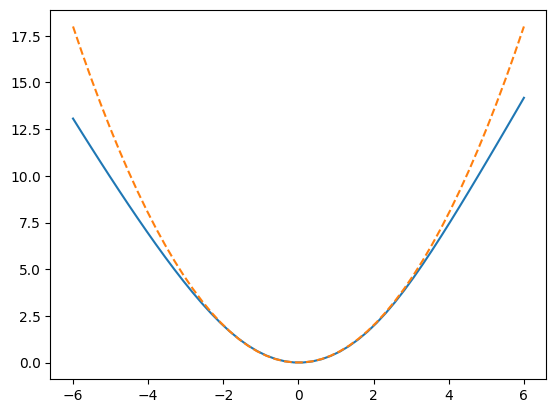

In [26]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-6, 6)

plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, ts**2 / 2, '--')

It does have trouble recovering more extreme values, even if we massively scale up the number of data points. I suspect that this is because we almost never sample such extreme values.

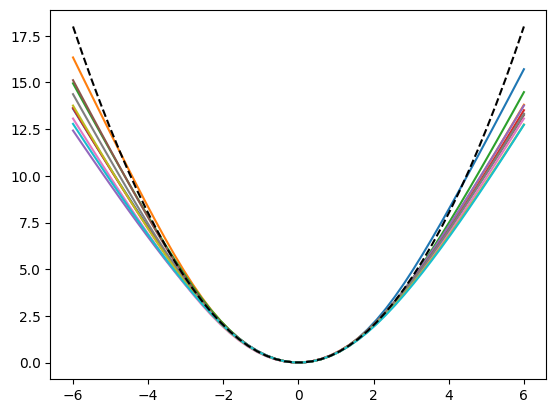

In [28]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-6, 6)

for i in range(10):
    data = np.random.randn(N)
    plt.plot(ts, make_CGF(ts, data))
    
plt.plot(ts, ts**2 / 2, '--k')

The results are, without doubt, negatively biased. This is not surprising given that the log is a concave function, but still a bit irritating.

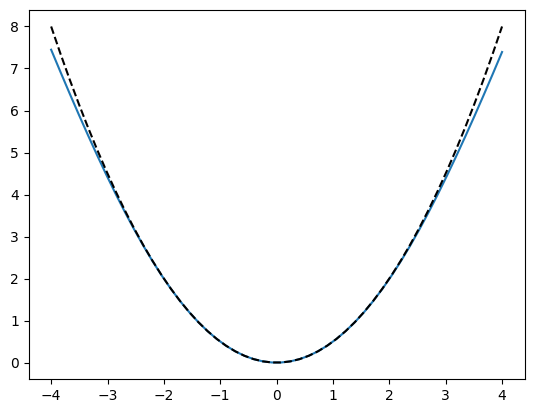

In [35]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)
tot = np.zeros(50)

for i in range(500):
    data = np.random.randn(N)
    #plt.plot(ts, make_CGF(ts, data))
    tot +=  make_CGF(ts, data)

plt.plot(ts, tot / 500)
plt.plot(ts, ts**2 / 2, '--k')

The negative bias again, only shows up in the tails, which I think is a result of their sparse sampling

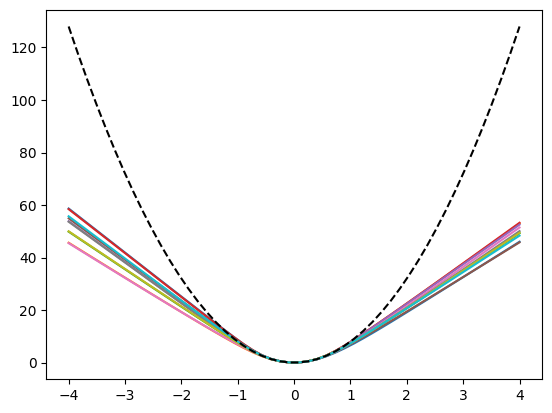

In [124]:
N = 5000

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)

for i in range(10):
    data = 4*np.random.randn(N)
    plt.plot(ts, make_CGF(ts, data))

plt.plot(ts, 4**2*ts**2 / 2, '--k')

Interestingly, increasing the variance of the distribution actually makes the fit worse at large distances.

This is more worrying. It is also quite interesting to me that the bias increases so much relative to the variance

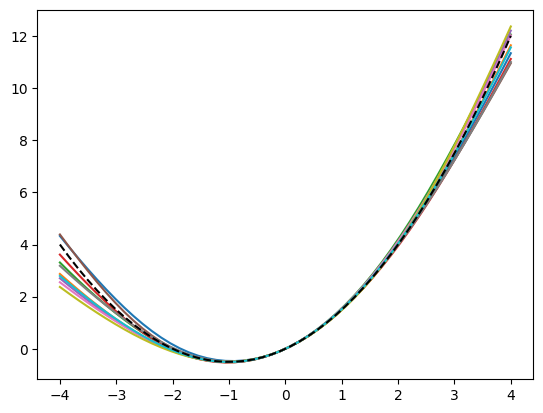

In [51]:
N = 5000

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)
tot = np.zeros(50)

for i in range(10):
    data = np.random.randn(N) + 1
    plt.plot(ts, make_CGF(ts, data))
    tot +=  make_CGF(ts, data)

plt.plot(ts, ts + ts**2 / 2, '--k')

The mean doesn't impact the fits. 

### Direct MGF fitting: does it remove the bias?

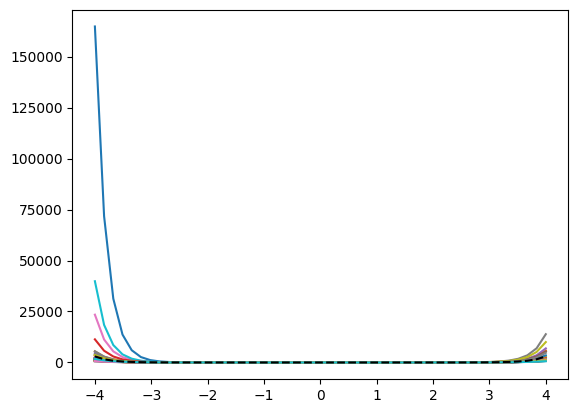

In [61]:
N = 5000

def make_MGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return outs

ts = np.linspace(-4, 4)

for i in range(50):
    data = np.random.randn(N)
    plt.plot(ts, make_MGF(ts, data))

plt.plot(ts, np.exp(ts**2 / 2), '--k')

Hard to tell if the same problem affects the MGF (without the log)

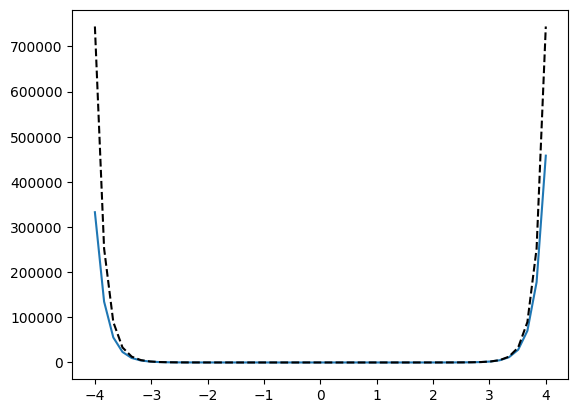

In [81]:
N = 5000

def make_MGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return outs

ts = np.linspace(-4, 4)

tot = np.zeros(50)
for i in range(500):
    data = 1.3*np.random.randn(N)
    tot += make_MGF(ts, data)

plt.plot(ts, tot / 500)
plt.plot(ts, np.exp((1.3**2)*ts**2 / 2), '--k')

Yeah, it's hard to tell, but it seems to me that the estimate is still undershooting the tails. This suggests that the bias is not caused by the log alone.

### Previous work by Dunfield et al. uses a batch sum in the exponent

Trying out that approach

Text(0.5, 1.0, 'Batch sum in exponent')

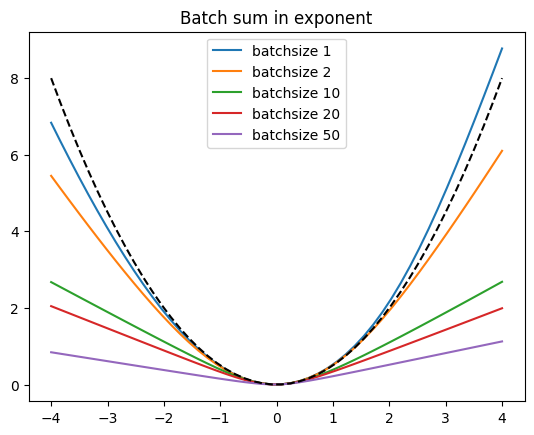

In [226]:
N = 5000

data = np.random.randn(N)

ts = np.linspace(-4, 4)

for b in [1, 2, 10, 20, 50]:
    blocks = np.split(data, N//b)
    block_sums = np.fromiter(map(np.sum, blocks), dtype=float)

    outs = []    
    for t in ts:
        outs.append( 1/b * np.log(np.exp(t*block_sums).mean()) )

    plt.plot(ts, outs, label=f'batchsize {b}')

plt.plot(ts, ts**2 / 2, '--k')
plt.legend()
plt.title('Batch sum in exponent')

Text(0.5, 1.0, 'Batch sum in exponent: double variance')

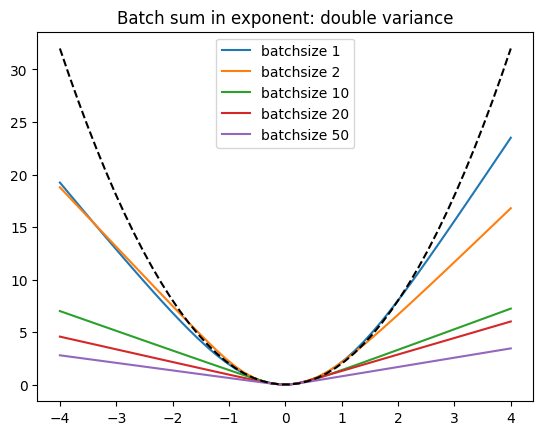

In [227]:
N = 5000

data = 2*np.random.randn(N)

ts = np.linspace(-4, 4)

for b in [1, 2, 10, 20, 50]:
    blocks = np.split(data, N//b)
    block_sums = np.fromiter(map(np.sum, blocks), dtype=float)

    outs = []    
    for t in ts:
        outs.append( 1./b * np.log(np.exp(t*block_sums).mean()) )

    plt.plot(ts, outs, label=f'batchsize {b}')

plt.plot(ts, 4*ts**2 / 2, '--k')
plt.legend()
plt.title('Batch sum in exponent: double variance')

Odd. This doesn't seem to improve the fit. It makes it worse.

In [139]:
np.exp(t*block_sums).mean()

9.644221993236841e+62

In [142]:
(b / N) *np.exp(t*block_sums).sum()

9.644221993236841e+62

One obvious problem is the sheer size of these sums: this will cause round off error itself.

In [180]:
np.log((b / N) *np.exp(t*block_sums).sum())

14.123517917093576

#### Thinking through the isses that we see here

1. It is clear that larger variance in the input variables results in larger bias in the output. Why is this?

We are getting functional forms, so there are a couple of tricks that we can play:
- standardizing
- averageing
followed by a varable transformation to undo them.

#### In the paper, they say:
- increasing the block size to reduce bias, and
- decreasing the block size to reduce variance.

By that metric, we have a variance problem.


### Why is there any bias at all?

It seems like the empirical MGF shouldn't have any bias, since the expectation of each term is the MGF term.

In [209]:
def extract_confidence_interval(bootstrap_result):
    return np.array([bootstrap_result.confidence_interval.low, bootstrap_result.confidence_interval.high])

In [229]:
data = np.random.randn(10000)

ts = np.linspace(0, 4, 10)
Mts = np.exp( ts**2 / 2)

empiricalMGF = lambda t, data: np.exp(t*data).mean()

means = []
CIs = []

for t in ts:
    confidence_interval = extract_confidence_interval( bootstrap((data,), lambda data: empiricalMGF(t, data)) )

    print(t)
    means.append(empiricalMGF(t, data))
    CIs.append(confidence_interval)

/usr/local/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/usr/local/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


0.0
0.4444444444444444
0.8888888888888888
1.3333333333333333
1.7777777777777777
2.2222222222222223
2.6666666666666665
3.1111111111111107
3.5555555555555554
4.0


In [235]:
CIs[0] = np.zeros(2)
CIs = np.array(CIs)

Text(0.5, 1.0, 'Bootstrap Empirical MGF')

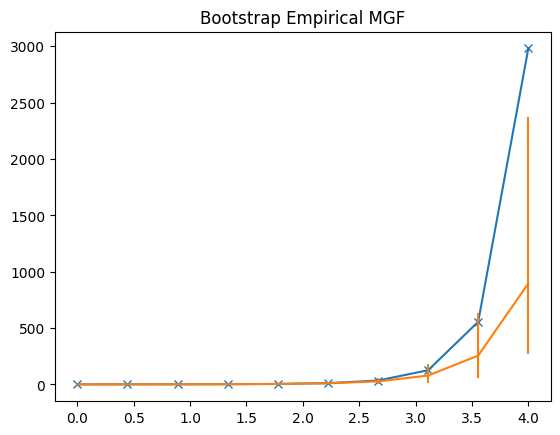

In [252]:
plt.plot(ts, Mts, '-x')
plt.errorbar(ts, means, yerr=CIs.T)
plt.title('Bootstrap Empirical MGF')

Text(0.5, 1.0, 'Bootstrap Empirical MGF - zoom')

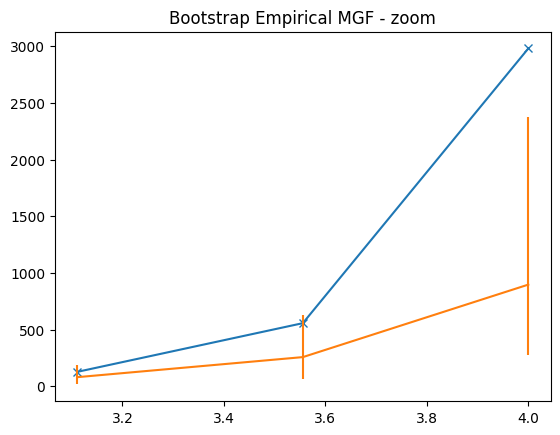

In [250]:
plt.plot(ts[-3:], Mts[-3:], '-x')
plt.errorbar(ts[-3:], means[-3:], yerr=CIs[-3:, :].T)
plt.title('Bootstrap Empirical MGF - zoom')

Yeah, like this is not even close at higher parameters.

I think that the reason for this is: for large values of the exponential, the distribution becomes very 'bottom heavy'. Any negative value contributes essentially a zero to the mean, while large positive values contribute an inordinately large amount. This means that the most important samples, the very large ones, we sample extremely rarely. Thus, we usually undershoot in our estimates of the mean because of our finite sample size. That is, the samples that overshoot do so massively, but become vanishingly rare.

In that sense, it's not really a bias. It's more like varaince that we only sample one part of.

#### Can we detect this by examining where the mean falls in the interval?

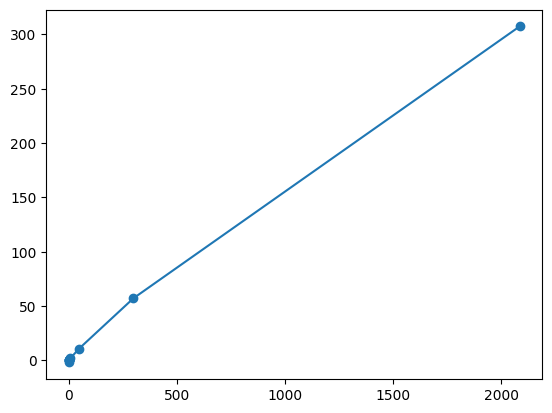

In [269]:
mean = np.array(means)

diff = Mts - mean
upper_vs_lower = (CIs - mean[:, None]).sum(axis=1)

plt.plot(diff, upper_vs_lower, '-o')

Yes, this looks like a fairly good way to detect such a thing.

### Using the bootstrap intervals to do bias correction?

In [275]:
diffs = (CIs - mean[:, None])

interval_ratio = diffs[:,1] / -diffs[:,0]

In [276]:
interval_ratio

array([-1.        ,  1.09468877,  1.05840991,  1.120734  ,  1.23253413,
        1.4362773 ,  1.497405  ,  1.71008678,  1.92726918,  2.12586604])

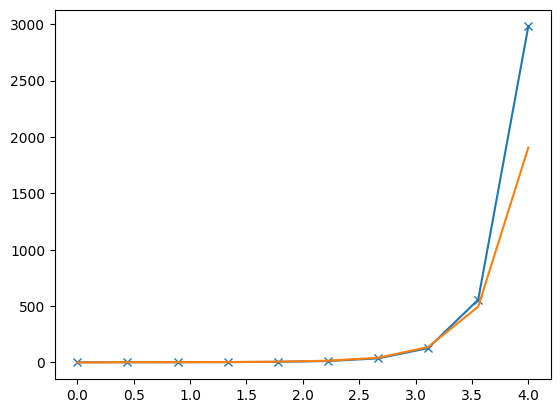

In [280]:
plt.plot(ts, Mts, '-x')
plt.plot(ts, means * interval_ratio)

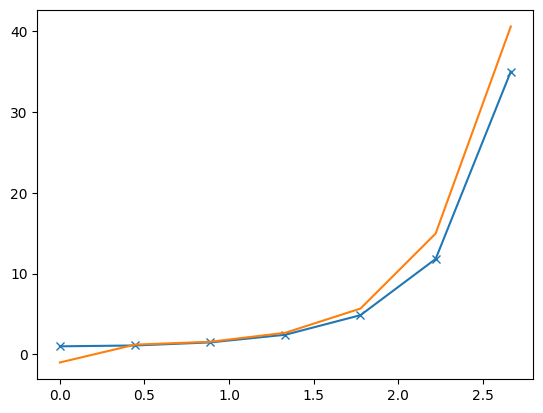

In [281]:
plt.plot(ts[:-3], Mts[:-3], '-x')
plt.plot(ts[:-3], means[:-3] * interval_ratio[:-3])

This gets us some of the way there: it improves the extreme estimates at the cost of over-shooting the lower ones. (Note that the first point at 0 is an artifact.)

### This is a well-known problem when estimating averages of heavy-tailed distributions.

I haven't (yet?) found a solution in the literature that uses the bootstrap intervals to correct estimates (like I tried above), but one commonly used approach seems to be a median of means.

In [333]:
data = np.random.randn(10000)
MGF_samples = np.exp(4*data)

target = np.exp(4**2/2)

splits = np.array(np.split(MGF_samples, 10000 // 10))
split_means = np.mean(splits, axis=1)

(-500.0, 20000.0)

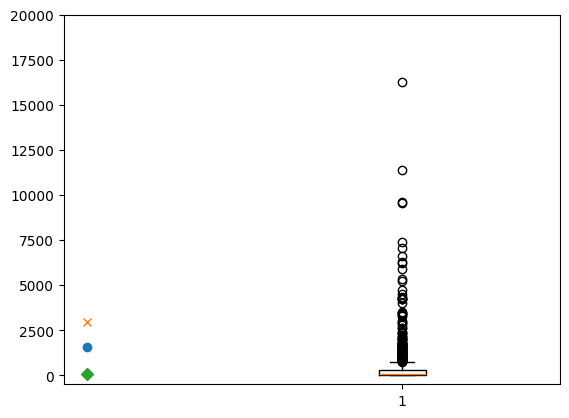

In [341]:
plt.boxplot(split_means)
plt.plot(MGF_samples.mean(), 'o')
plt.plot(target, 'x')
plt.plot(np.median(split_means), 'D')
plt.ylim([-500, 20000])

Ok, it is clear that the sub-sample means do surround the true mean, as well as the empirical means (note that I'm enforcing a max on the y axis so that the behavior is actually visible, individual samples go even higher).

However the basic median is not enough to recover the behavior. They use a geometric median? (geometric median == median in one dimension...)

This seems promising, but a little backward. We want an estimator that is _more_ sensitive to outliers in the mean, not less.



In [342]:
target

2980.9579870417283

In [343]:
MGF_samples.mean()

1562.113953496714

In [344]:
np.median(split_means)

65.39609856853268

In [345]:
np.mean(split_means)

1562.113953496714

In [578]:
splits

array([[3.52546956e-01, 3.48758590e-01, 8.96624203e+00, ...,
        2.36037981e+01, 4.20128605e+02, 9.61781926e+00],
       [1.39108861e+01, 1.13081846e-03, 2.21206376e+01, ...,
        3.02749739e+00, 1.74314355e-02, 6.37985859e-05],
       [7.58329854e+02, 6.23089255e-01, 1.09909587e-01, ...,
        1.22807601e-03, 2.45820430e+03, 8.00196599e+00],
       ...,
       [2.74042485e+00, 3.10510680e-01, 5.90780529e-01, ...,
        1.77394323e-01, 8.68432258e-01, 1.14313856e-02],
       [3.60082617e-02, 1.83347553e-01, 2.39395291e+03, ...,
        6.26020104e-01, 6.03613620e-01, 1.00903352e+02],
       [5.01870398e-03, 4.09179105e-02, 5.74874184e-01, ...,
        1.17286502e+03, 2.77410619e+00, 1.20938614e+00]])

### Trying out stabs at solutions


In [529]:
a = 2
data = a*np.random.randn(2000)

In [530]:
def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

def true_CGF(ts):
    return a**2 * ts**2 / 2

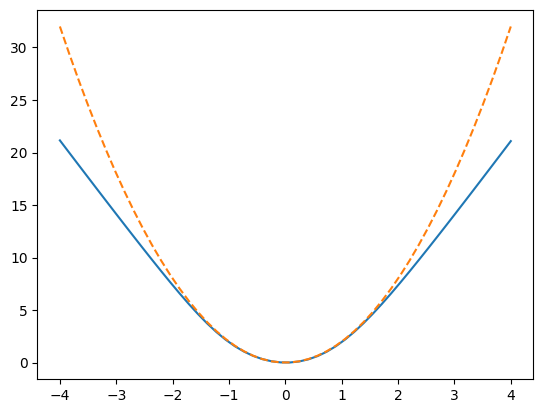

In [531]:
plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, true_CGF(ts), '--')

### integration in the y domain

This reminds me of the change of variables that we needed in the problem with dad. Can we do an alternative empirical estimate by weighting by the width of the bins

Rather than evaluating at each sample, we bin the data, evaluate at the midpoints of the bins, and weight by the frequency of samples in each bin.

In [532]:
def data_domain(data, N=1000):
    """ regularly spaced intervals that cover all of the data """
    min = np.floor(data.min())
    max = np.ceil(data.max())

    return np.linspace(min, max, N)


In [533]:
def approximate_integral(data, func):
    dom = data_domain(data, 1000)
    counts, bins = np.histogram(data, dom)
    freqs = counts / data.shape[0]
    midpoints = (bins[:-1] + bins[1:])/2
    

    return (freqs * func(midpoints)).sum()


In [534]:
approximate_integral(data, lambda x: np.exp(x))

7.0197769875938185

In [535]:
ts = np.linspace(-4, 4)

pure_emp = []
density_emp = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    density_emp.append( np.log(approximate_integral(data, lambda x: np.exp(t*x))) )

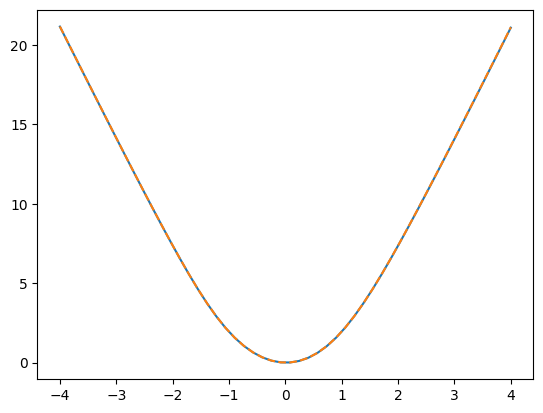

In [554]:
plt.plot(ts, pure_emp)
plt.plot(ts, density_emp, '--')

Now we do the same thing in the space of function outputs.

In [537]:
def approximate_integral_transform(data, func):
    dom = data_domain(data, 1000)
    counts, bins = np.histogram(data, dom)
    freqs = counts / data.shape[0]

    y_edges = func(bins)
    midpoints = (y_edges[:-1] + y_edges[1:])/2
    
    return (freqs * midpoints).sum()


In [538]:
ts = np.linspace(-4, 4)

pure_emp = []
density_emp_transform = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    density_emp_transform.append( np.log(approximate_integral_transform(data, lambda x: np.exp(t*x))) )

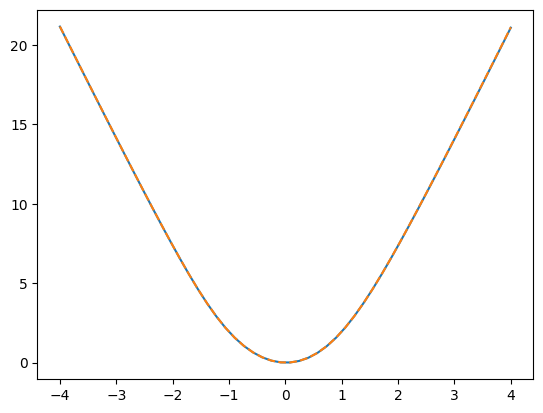

In [539]:
plt.plot(ts, pure_emp)
plt.plot(ts, density_emp_transform, '--')

Ok, this is actually identical to the other methods. Nice to see, but also annoying.

### What about using a kernel density estimator?

In [540]:
from scipy.stats import gaussian_kde

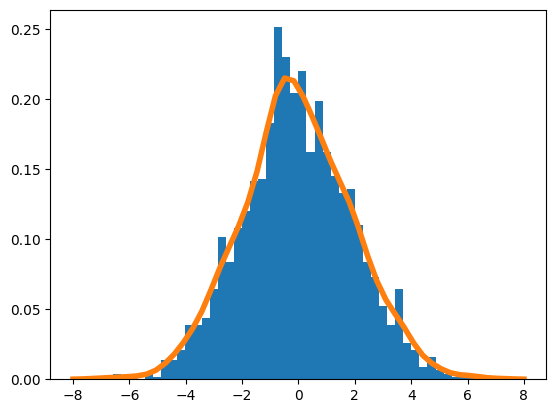

In [545]:
kde = gaussian_kde(data)

xs = np.linspace(-8,8)
plt.hist(data, bins=50, density=True)
plt.plot(xs, kde.pdf(xs), linewidth=4)

In [546]:
from scipy.integrate import quad

In [547]:
quad(lambda x: np.exp(4*x) * kde.pdf(x), -8, 8)

(3947952594.564083, 3.230903417104855)

In [571]:
def kde_integral(data, func):
    kde = gaussian_kde(data)
    return quad(lambda x: func(x) * kde.pdf(x), -10, 10)[0]

In [572]:
ts = np.linspace(-4, 4)

pure_emp = []
kde_est = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    kde_est.append( np.log(kde_integral(data, lambda x: np.exp(t*x))) )

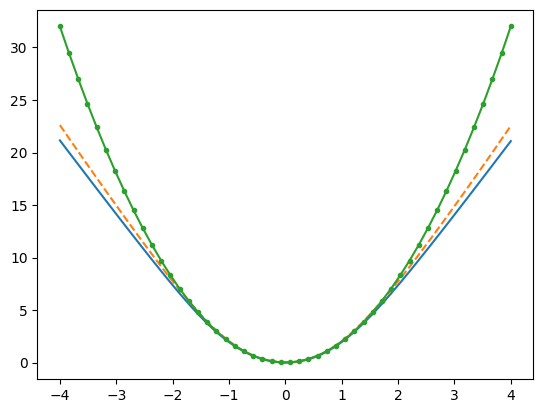

In [573]:
plt.plot(ts, pure_emp)
plt.plot(ts, kde_est, '--')
plt.plot(ts, true_CGF(ts), '.-')

Very slow. Slight improvement, but still significantly too low.

### Is this behavior actually correct?

After all, by Cramer's theorem, the limiting slope reflects the CDF at extreme points.

When it becomes linear, the Legendre transform of on larger slopes goes to infinity. This is actually exactly what should happen

In [8]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4, 25)

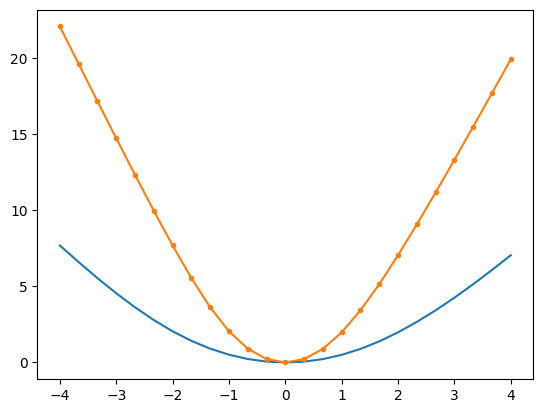

In [9]:
plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, make_CGF(ts, 2*data), '.-')

The limiting slope _increases_ with larger variance, as we would expect

### Does the limiting slope reflect the largest obervation?

In [53]:
max_values = []
max_slopes = []

min_values = []
min_slopes = []

ts = np.linspace(-4, 4, 31)
delta_t = ts[1] - ts[0]

for rep in range(20):
    data = np.random.randn(200)
    CGF = make_CGF(ts, data)

    max_values.append(data.max())
    min_values.append(data.min())

    max_slopes.append((CGF[-1] - CGF[-2]) / delta_t)
    min_slopes.append((CGF[1] - CGF[0]) / delta_t)


Text(0, 0.5, 'Max slope')

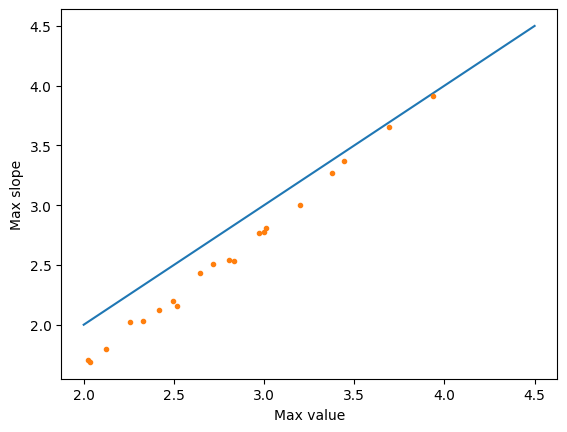

In [54]:
plt.plot(np.linspace(2, 4.5), np.linspace(2,4.5))
plt.plot(max_values, max_slopes, '.')
plt.xlabel('Max value')
plt.ylabel('Max slope')

Text(0, 0.5, 'Min slope')

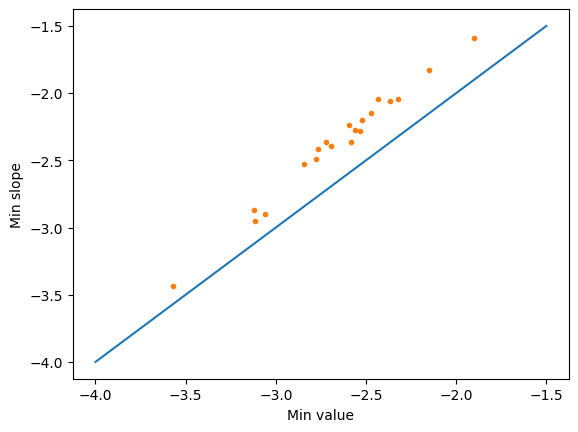

In [55]:
plt.plot(np.linspace(-1.5, -4), np.linspace(-1.5,-4))
plt.plot(min_values, min_slopes, '.')
plt.xlabel('Min value')
plt.ylabel('Min slope')

The relationship between the min/max value and the min/max slope is indeed quite linear.

It doesn't perfectly line up: the maximum slope slightly, undershoots the max value, while the minimum slope slightly overshoots.

In [59]:
max_values = []
max_slopes = []

min_values = []
min_slopes = []

ts = np.linspace(-8, 8, 81)
delta_t = ts[1] - ts[0]

for rep in range(20):
    data = np.random.randn(200)
    CGF = make_CGF(ts, data)

    max_values.append(data.max())
    min_values.append(data.min())

    max_slopes.append((CGF[-1] - CGF[-2]) / delta_t)
    min_slopes.append((CGF[1] - CGF[0]) / delta_t)



Text(0, 0.5, 'Max slope')

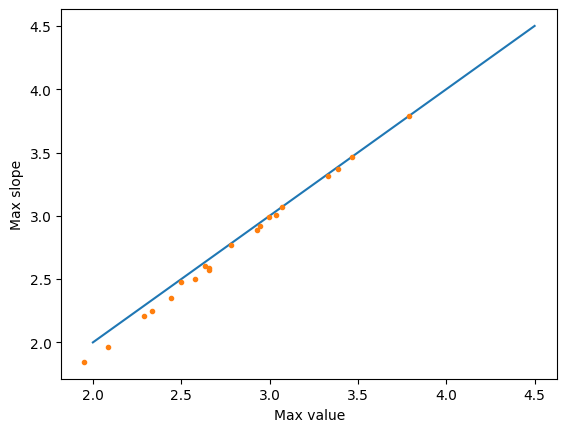

In [60]:
plt.plot(np.linspace(2, 4.5), np.linspace(2,4.5))
plt.plot(max_values, max_slopes, '.')
plt.xlabel('Max value')
plt.ylabel('Max slope')

Text(0, 0.5, 'Min slope')

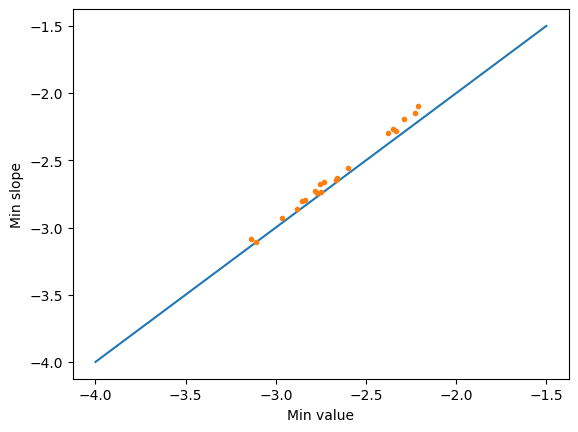

In [61]:
plt.plot(np.linspace(-1.5, -4), np.linspace(-1.5,-4))
plt.plot(min_values, min_slopes, '.')
plt.xlabel('Min value')
plt.ylabel('Min slope')

Increasing the domain that we use to evaluate the MGF improves the relationship. Note that this uses only a small amount of data, in order to get hetergeneous maxima.

### Answer:
Yes, the limiting slopes seem to reflect the maximum observed values very well. This fits perfectly the intuition behind the slopes saturating due to limits the our observed dataset.

## 2. Comparison of rate function to CDF

This is a question of how Cramer's theorem works, and how it applies to the empirical CDFs.

In [3]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

In [4]:
def legendre_basic(dualxs, ts, CGF):
    """Simple and hacky lagendre transform"""

    max_slope = (CGF[-1] - CGF[-2])/(ts[-1] - ts[-2])
    min_slope = (CGF[1] - CGF[0])/(ts[1] - ts[0])

    dual_vals = []
    for x in dualxs:
        if x < min_slope:
            dual_vals.append(float('inf'))
        elif x > max_slope:
            dual_vals.append(float('inf'))
        else:
            values = x*ts - CGF
            dual_vals.append(np.max(values))

    return np.array(dual_vals)

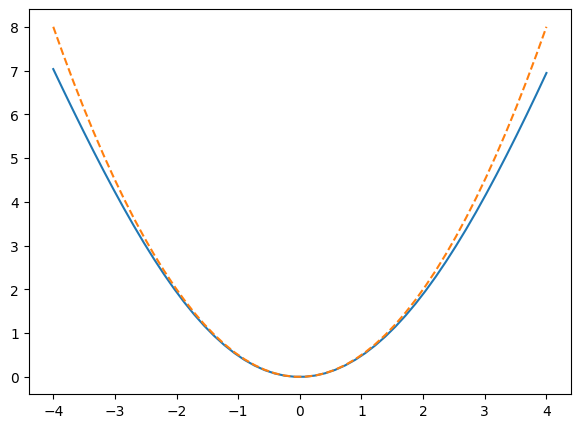

In [5]:
figsize(7,5)
ts = np.linspace(-4, 4)
CGF = make_CGF(ts, data)

plt.plot(ts, CGF)
plt.plot(ts, ts**2 / 2, '--')

Taking the empirical Dual

In [6]:
xs = np.linspace(-4, 4)
dual = legendre_basic(xs, ts, CGF)

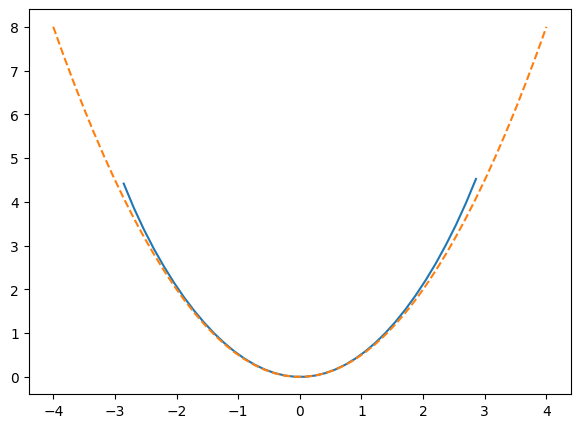

In [7]:
plt.plot(xs, dual)
plt.plot(xs, xs**2 / 2, '--')

Looks great for a simple example:

The dual of $\frac{x^2}{2}$ is $\frac{x^2}{2}$. The dual goes to infinity where the slope becomes constant (by force, but it should do that)

In [8]:
def dual_to_CGF(xs, dual):
    """ this is where Cramers theorem comes into play """

    out = np.exp(-dual)
    out[xs > 0] = 1. - out[xs > 0]
    return out

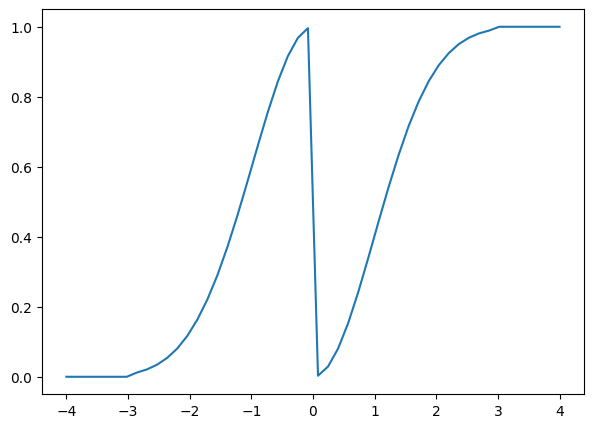

In [9]:
plt.plot(xs, dual_to_CGF(xs, dual))

This shows an inconvient fact about the dual: at the mean (median), it evaluates to zero, which means that the CGF derived here goes to 1.

However, it should be 1/2 based on the fact that it is the median.

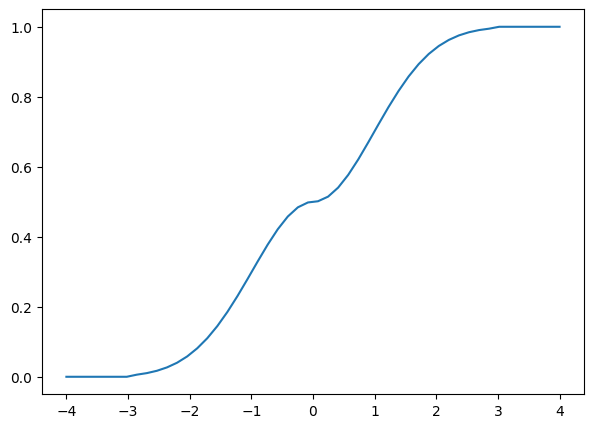

In [10]:
def dual_to_CGF_hack(xs, dual):
    """ this is where Cramers theorem comes into play """

    out = 00.5*np.exp(-dual)
    out[xs > 0] = 1. - out[xs > 0]
    return out
    
plt.plot(xs, dual_to_CGF_hack(xs, dual))

In [11]:
# empirical CDF
from scipy.stats import ecdf

data_cdf = ecdf(data)

In [12]:
ecdf(data).cdf

EmpiricalDistributionFunction(quantiles=array([-3.40551319, -3.33949269, -3.27589737, ...,  3.12366414,
        3.28004848,  3.6006286 ]), probabilities=array([2.000e-04, 4.000e-04, 6.000e-04, ..., 9.996e-01, 9.998e-01,
       1.000e+00]))

Text(0.5, 1.0, 'Comparing Rate function to the empirical CDF')

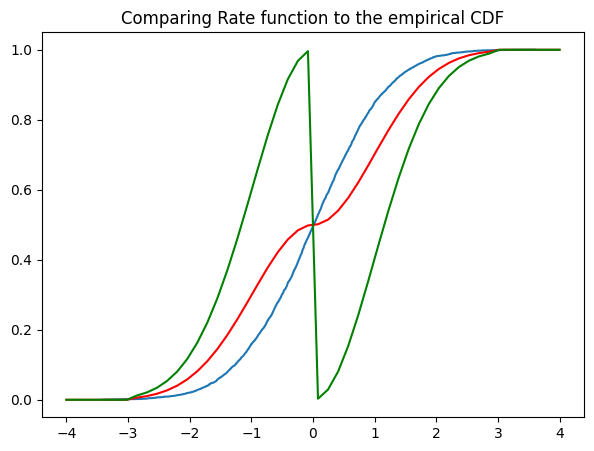

In [13]:
plt.plot(data_cdf.cdf.quantiles, data_cdf.cdf.probabilities)

plt.plot(xs, dual_to_CGF_hack(xs, dual), 'r')
plt.plot(xs, dual_to_CGF(xs, dual),'g')

plt.title('Comparing Rate function to the empirical CDF')

Neither of these look good, either in the middle or even at the extremes, short of where it becomes constant.

There is also the inconvient fact that we know this to be the incorrect CDF:

We have: $1-\exp(-x^2/2)$ for positive values

but we know that the normal CDF does not have a closed form. How can Cramers hold true:
- instant note: Cramer is for CDF of means as samples to infinity

### Does it accurately capture the limiting behavior of the means? 

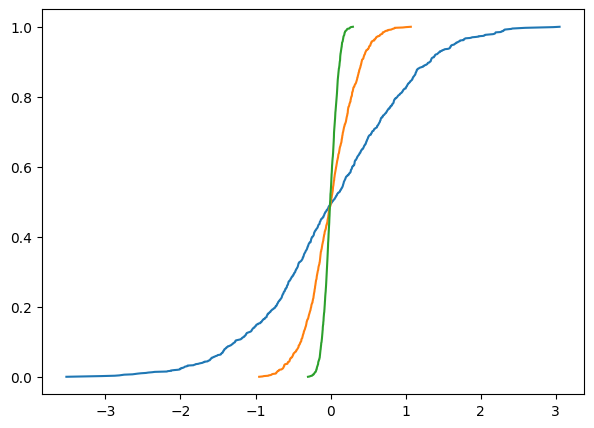

In [14]:
def mean_cdf(n, Ntotal):
    samples = [np.mean(np.random.randn(n)) for i in range(Ntotal)]
    cdf = ecdf(samples)

    return cdf.cdf.quantiles, cdf.cdf.probabilities

plt.plot(*mean_cdf(1, 1000))
plt.plot(*mean_cdf(10, 1000))
plt.plot(*mean_cdf(100, 1000))

Text(0.5, 1.0, 'Limiting behavior: n = 1')

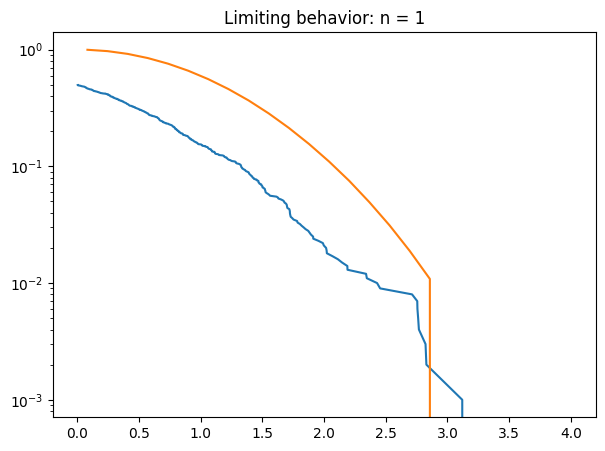

In [15]:
n_mean = 1
xs_emp, CDF_emp = mean_cdf(n_mean, 1000)

plt.semilogy(xs_emp[xs_emp>0], 1 - CDF_emp[xs_emp>0])
plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))

plt.title(f'Limiting behavior: n = {n_mean}')

Text(0.5, 1.0, 'Limiting behavior: n = 10')

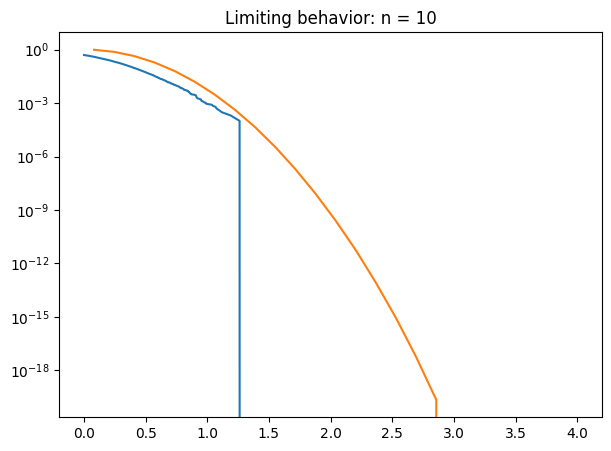

In [16]:
n_mean = 10
xs_emp, CDF_emp = mean_cdf(n_mean, 1000*n_mean)

plt.semilogy(xs_emp[xs_emp>0], 1 - CDF_emp[xs_emp>0])
plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))

plt.title(f'Limiting behavior: n = {n_mean}')


Text(0.5, 1.0, 'Limiting behavior: n = 100')

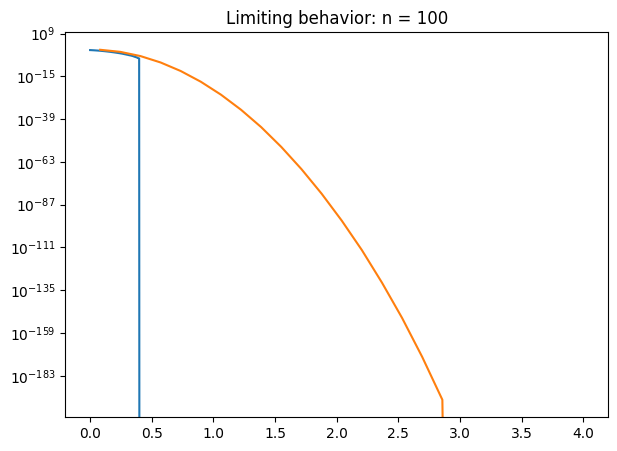

In [17]:
n_mean = 100
xs_emp, CDF_emp = mean_cdf(n_mean, 1000*n_mean)

plt.semilogy(xs_emp[xs_emp>0], 1 - CDF_emp[xs_emp>0])
plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))

plt.title(f'Limiting behavior: n = {n_mean}')

As we increase the number of samples, the empirical mean becomes more concentrated around 1.

Text(0.5, 1.0, 'Limiting behavior with CDF of sum instead of mean: n = 100')

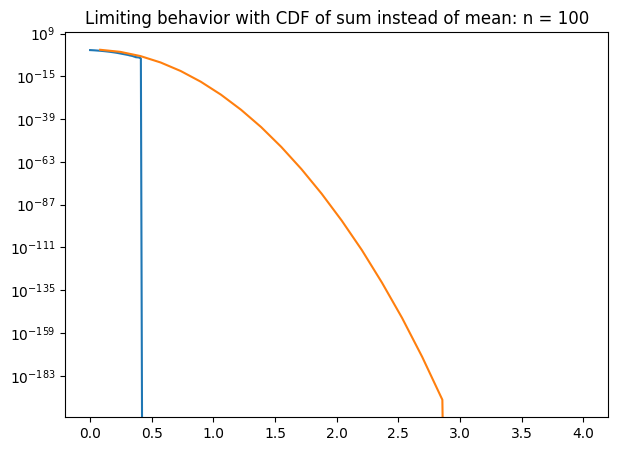

In [18]:
def sum_cdf(n, Ntotal):
    samples = [np.sum(np.random.randn(n)) for i in range(Ntotal)]
    cdf = ecdf(samples)

    return cdf.cdf.quantiles, cdf.cdf.probabilities

n_mean = 100
xs_emp, CDF_emp = sum_cdf(n_mean, 1000*n_mean)

plt.semilogy(xs_emp[xs_emp>0] / n_mean, 1 - CDF_emp[xs_emp>0])
plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))

plt.title(f'Limiting behavior with CDF of sum instead of mean: n = {n_mean}')

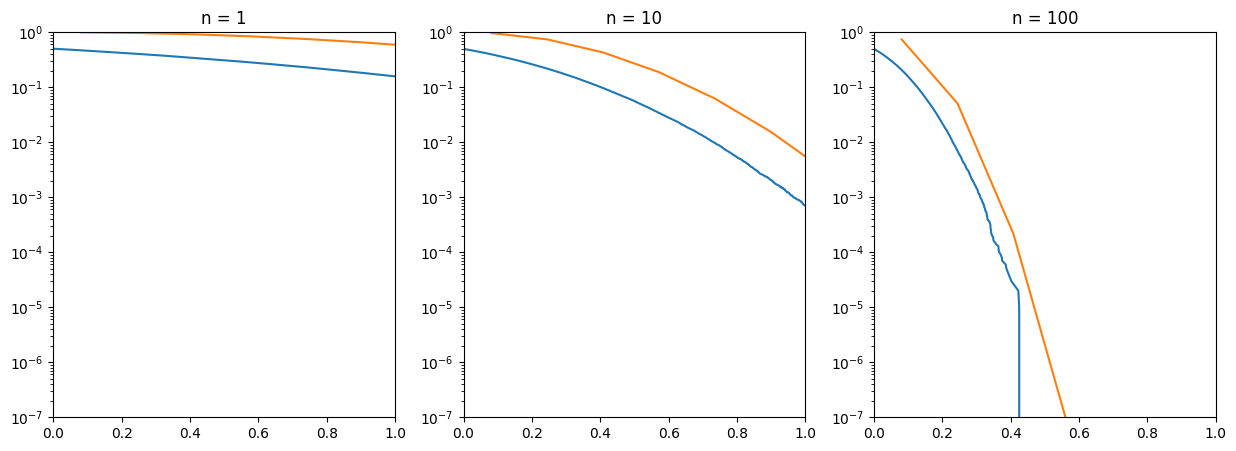

In [19]:
figsize(15,5)
plt.subplots(1,3)

for i, n_mean in enumerate([1, 10, 100]):
    xs_emp, CDF_emp = mean_cdf(n_mean, 100000)

    plt.subplot(1,3, i+1)
    plt.semilogy(xs_emp[xs_emp>0], 1 - CDF_emp[xs_emp>0])
    plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))
    
    plt.title(f'n = {n_mean}')
    plt.ylim([1E-7, 1])
    plt.xlim([0, 1])

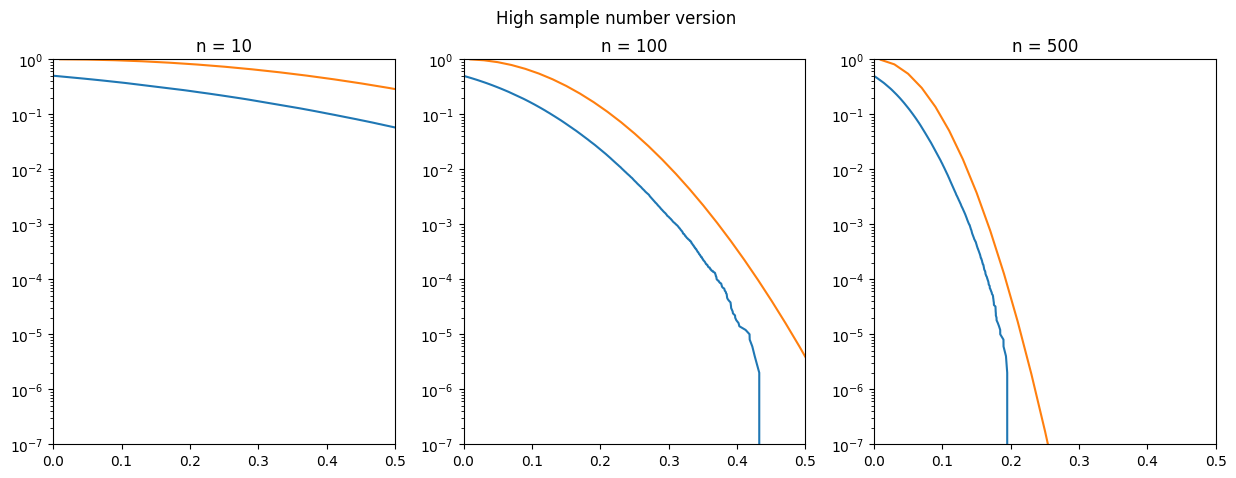

In [20]:
figsize(15,5)
plt.subplots(1,3)
plt.suptitle('High sample number version')

data = np.random.randn(500000)
ts = np.linspace(-5, 5, 500)
CGF = make_CGF(ts, data)

xs = np.linspace(-5, 5, 500)
dual = legendre_basic(xs, ts, CGF)


for i, n_mean in enumerate([10, 100, 500]):
    xs_emp, CDF_emp = mean_cdf(n_mean, 500000)

    plt.subplot(1,3, i+1)
    plt.semilogy(xs_emp[xs_emp>0], 1 - CDF_emp[xs_emp>0])
    plt.semilogy(xs[xs>0], np.exp(-n_mean * dual[xs>0]))
    
    plt.title(f'n = {n_mean}')
    plt.ylim([1E-7, 1])
    plt.xlim([0, 0.5])

#### These appear to be converging (As Cramers says they should)

That is especially the case, since the y axis is a log scale, so distances high up on the axis are more significant that differences low down.

This highlights what Cramers theorem is all about: the limiting behavior of averages as their distribution gets more and more tightly concentrated around the mean (due to the large numbers of samples). In particular, as the CDF goes to zero faster and faster, the rate function holds better.

The question that follows is: (how) can we use the rate function that we have to detect changes in the input statistics? It will not be as easy as using a simple KS test, I don't think, because we might need very large means in order for our rate function to capture the limiting CDF.

Questions:
 - Would a bootstrap produce something different? (probably not)

## 3. Fitting CGF using ICNN

### What domain should we use for out empirical CGF?



In [44]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

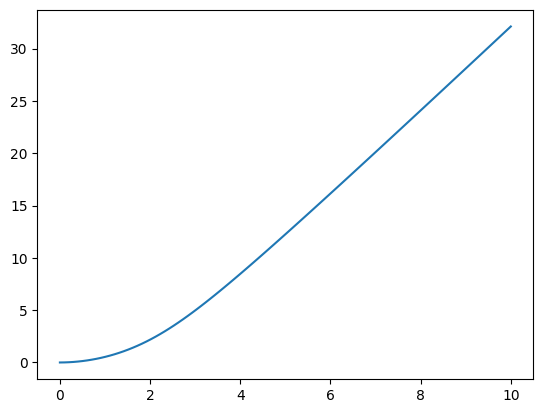

In [45]:
xs = np.linspace(0, 10, 100)
CGF = make_CGF(xs, data)

plt.plot(xs, CGF)

In [46]:
(CGF[-1] - CGF[-2]) / (xs[-1] - xs[-2])

4.023502525452173

In [47]:
data.max()

4.052506081106049

Since the maximum value determines the maximum slope (and vice versa for minima), finding the t values that achieve close to maximal slope allows us to determined the range of $t$ that we need to use for training the convex network representation of the CGF.

__Q:__ What about higher dimensional data?

In [80]:
N = 5000
data = np.random.randn(N,2)

def make_CGF(ts, data):
    outs =  np.exp(data@ts).mean(axis=0)
    return np.log(outs)



In [91]:
xs = np.linspace(-12, 12, 100)
ys = np.linspace(-12, 12, 100)

X, Y = np.meshgrid(xs, ys)

coordinates = np.stack([X, Y])
CGF = make_CGF( coordinates.reshape(2, -1), data)

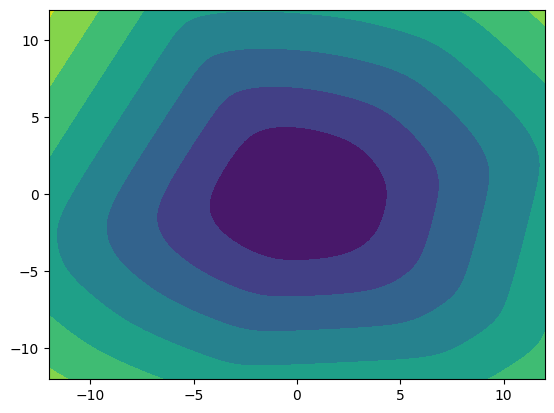

In [92]:
plt.contourf(X, Y, CGF.reshape(100, 100))

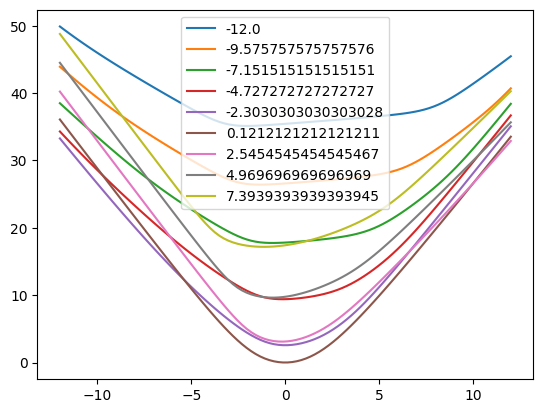

In [103]:
CGF = CGF.reshape(100, 100)
for i in range( 9):
    plt.plot(X[10*i, :], CGF[10*i, :], label=Y[10*i, 0])

plt.legend()

Hmmm, there seems to be a common limiting slope in many places, but not everywhere. The limiting slope at very low $y$ values does not agree. However, it's possible that these locations simply require larger $x$ values to see the limiting slopes.

In [105]:
(CGF[50, -1] - CGF[50, -2]) / (X[50, -1] - X[50, -2] )

3.462690180837335

In [106]:
(CGF[50, 1] - CGF[50, 0]) / (X[50, 1] - X[50, 0] )

-3.6513722605841124

In [108]:
data[:,0].max()

3.4986838458735376

In [109]:
data[:, 0].min()

-3.685707941329989

Same calculation for $y$

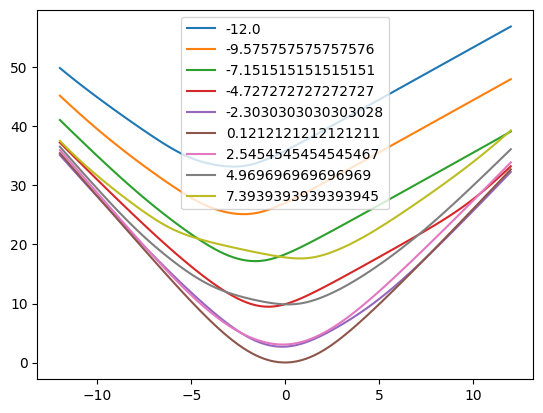

In [110]:
for i in range( 9):
    plt.plot(Y[:, 10*i], CGF[:, 10*i], label=X[0, 10*i])

plt.legend()

In [112]:
(CGF[-1, 50] - CGF[-2, 50]) / (Y[-1, 50] - Y[-2, 50] )

3.361071028299384

In [113]:
data[:,1].max()

3.416332125506367

In [114]:
(CGF[1, 50] - CGF[0, 50]) / (Y[1, 50] - Y[0, 50] )

-3.657062838067399

In [115]:
data[:,1].min()

-3.662576281376377

Ok, yes. Generally, it appears that we can just look at the limiting slopes along the axes. I'm not sure whether there is any meaning that can be gained from the dependence between the slopes in either direction: maybe this has to do with the data copula.

Potential question for later. Not for right now.

In [124]:
import torch
def axis_samples(samples, n_axis, n_total):
    all_data = []
    for ind in range(n_total):
        if ind == n_axis:
            all_data.append(samples)
        else:
            all_data.append(torch.zeros(len(samples)))
    return torch.stack(all_data)

In [126]:
samps = axis_samples(torch.linspace(0, 3, 55), 2, 4)

In [127]:
samps.shape

torch.Size([4, 55])

### Fitting the model itself

In [3]:
%run icnn.py
from models.trainers import trainModel

In [4]:
data = np.random.randn(1000,2)
model = CGF_ICNN(data)

In [5]:
trainModel(model, 'trainedParameters/CGFnet')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lrast. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | initialLayer   | Linear     | 30     | train
1 | internalLayers | ModuleList | 66     | train
2 | shortcutLayers | ModuleList | 21     | train
3 | nlin           | CELU       | 0      | train
4 | lossFn         | MSELoss    | 0      | train
------------------------------------------------------
117       Trainable

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1000` reached.


Train Loss,█▆▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,██▇▇▇▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇████
trainer/global_step,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Train Loss,0.05652
Val Loss,0.04635
epoch,999
trainer/global_step,49999


'/Users/luke/Documents/learnedExpFam/trainedParameters/CGFnet/validation-epoch=951-step=47600.ckpt'

The following uses the over-trained version, but thats ok for now.

In [57]:
model = CGF_ICNN.load_from_checkpoint('trainedParameters/CGFnet/validation-epoch=951-step=47600.ckpt',
                                      data_to_model=data)

In [58]:
def make_CGF(ts, data):
    """ compute empirical CGF """
    outs = np.exp(data @ ts.T).mean(axis=0)
    return np.log(outs)


xs = np.linspace(-12, 12, 100)
ys = np.linspace(-12, 12, 100)

X, Y = np.meshgrid(xs, ys)

coordinates = np.stack([X, Y])
coordinates = coordinates.reshape(2, -1)
CGF = make_CGF( coordinates.T, data)

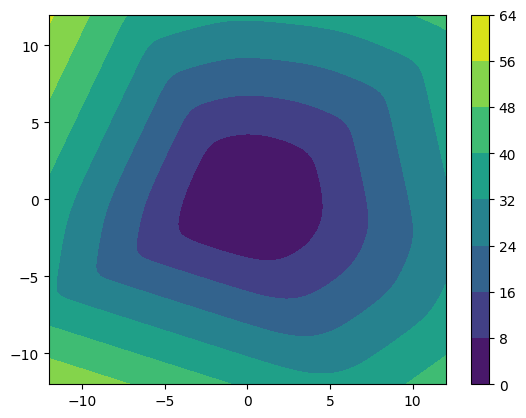

In [59]:
plt.contourf(X, Y, CGF.reshape(100,100))
plt.colorbar()

In [62]:
outputs = model.forward(torch.tensor(coordinates.T, dtype=torch.float32).to(model.device)).cpu()

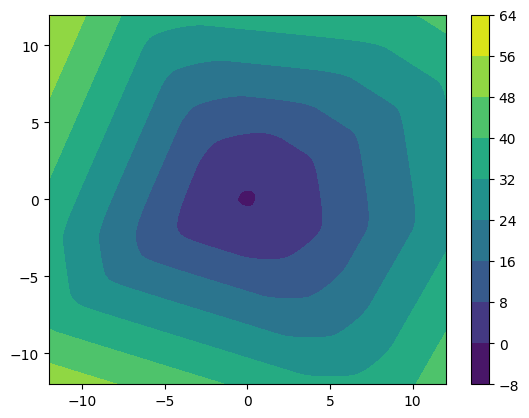

In [63]:
plt.contourf(X, Y, outputs.detach().reshape(100, 100))
plt.colorbar()

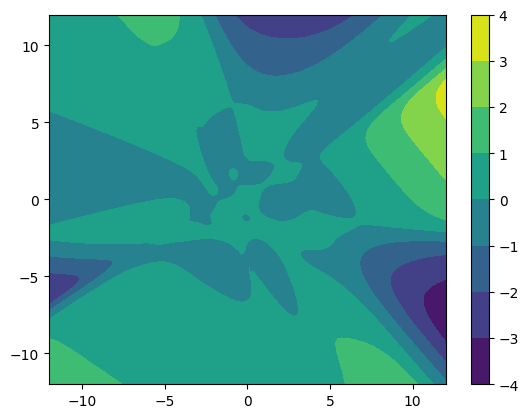

In [64]:
diff = CGF.reshape(100,100) - outputs.detach().reshape(100, 100).numpy()
plt.contourf(X, Y, diff)
plt.colorbar()

Text(0.5, 1.0, 'Overlay')

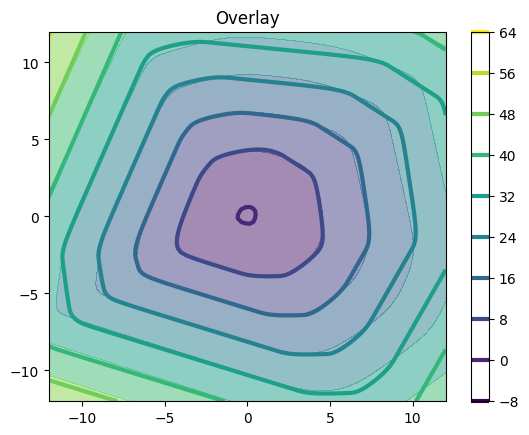

In [65]:
plt.contourf(X, Y, CGF.reshape(100,100), alpha=0.5)
plt.contour(X, Y, outputs.detach().reshape(100, 100), linewidths=3)
plt.colorbar()
plt.title('Overlay')

Overall, this looks pretty good. It's certainly learning something.

I do wish that the boundaries lined-up a bit better. Especially for the further-out regions of 

In [68]:
model.setup()

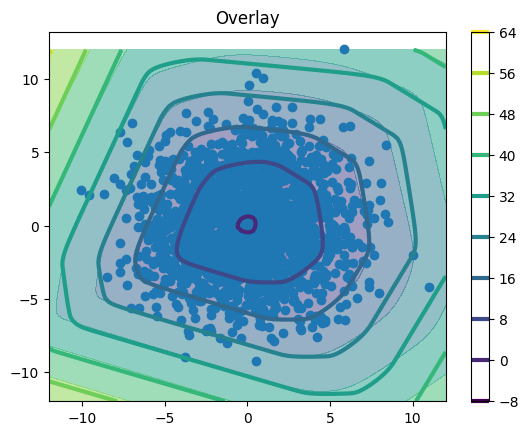

In [74]:
plt.contourf(X, Y, CGF.reshape(100,100), alpha=0.5)
plt.contour(X, Y, outputs.detach().reshape(100, 100), linewidths=3)
plt.colorbar()
plt.title('Overlay')

plt.scatter(model.ts[:,0], model.ts[:,1])

Ok, so the data is definitely more clustered than the region that we are plotting over.

In [76]:
xs = np.linspace(-7, 7, 100)
ys = np.linspace(-7, 7, 100)

X, Y = np.meshgrid(xs, ys)

coordinates = np.stack([X, Y])
coordinates = coordinates.reshape(2, -1)
CGF = make_CGF( coordinates.T, data)

outputs = model.forward(torch.tensor(coordinates.T, dtype=torch.float32).to(model.device)).cpu()

Text(0.5, 1.0, 'Overlay - zoom')

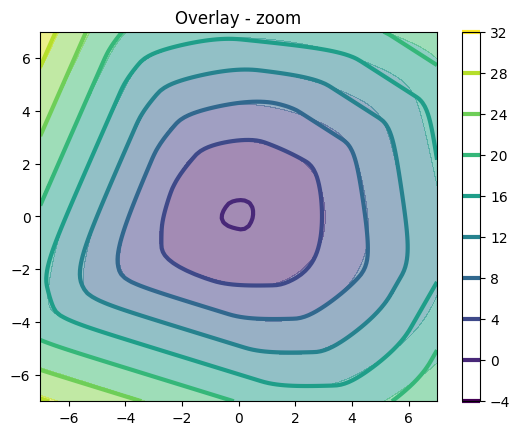

In [81]:
plt.contourf(X, Y, CGF.reshape(100,100), alpha=0.5)
plt.contour(X, Y, outputs.detach().reshape(100, 100), linewidths=3)
plt.colorbar()
plt.title('Overlay - zoom')

#plt.scatter(model.ts[:,0], model.ts[:,1])

The zoomed in version looks pretty good.

__Overall__, the ICNN is learning well. I do wish that the limiting behavior was better captured by the network, but of course there is always a tradeoff between this and the small scale.

_Question:_ which is more important for our purposes?

#### A run with more dispersed data

In [83]:
data = np.random.randn(1000,2)
model = CGF_ICNN(data)

trainModel(model, 'trainedParameters/CGFnet/more_spread')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | initialLayer   | Linear     | 30     | train
1 | internalLayers | ModuleList | 66     | train
2 | shortcutLayers | ModuleList | 21     | train
3 | nlin           | CELU       | 0      | train
4 | lossFn         | MSELoss    | 0      | train
------------------------------------------------------
117       Trainable

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Train Loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
trainer/global_step,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,0.01919
Val Loss,0.03202
epoch,837
trainer/global_step,41899


'/Users/luke/Documents/learnedExpFam/trainedParameters/CGFnet/more_spread/validation-epoch=787-step=39400.ckpt'

In [88]:
model = CGF_ICNN.load_from_checkpoint('trainedParameters/CGFnet/more_spread/validation-epoch=787-step=39400.ckpt',
                                      data_to_model=data)
model.setup()

In [89]:
xs = np.linspace(-12, 12, 100)
ys = np.linspace(-12, 12, 100)

X, Y = np.meshgrid(xs, ys)

coordinates = np.stack([X, Y])
coordinates = coordinates.reshape(2, -1)
CGF = make_CGF( coordinates.T, data)

outputs = model.forward(torch.tensor(coordinates.T, dtype=torch.float32).to(model.device)).cpu()

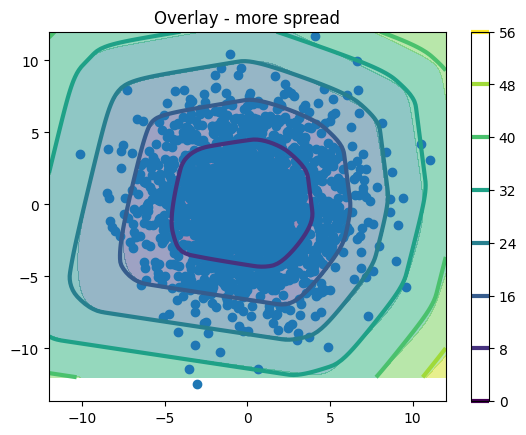

In [90]:
plt.contourf(X, Y, CGF.reshape(100,100), alpha=0.5)
plt.contour(X, Y, outputs.detach().reshape(100, 100), linewidths=3)
plt.colorbar()
plt.title('Overlay - more spread')
plt.scatter(model.ts[:,0], model.ts[:,1])

Spimilar to previously. Hard to see much of a difference.

## 4. Extract the internal activations of a trained network

In [91]:
from models.model_face_angle import FaceAngle

In [93]:
model = FaceAngle.load_from_checkpoint('trainedParameters/classifier/initial/validation-epoch=556-step=21166.ckpt')

In [122]:
model.setup()
data = model.trainData.images.reshape(-1, 64*64).to(model.device)

In [137]:
model.model

Sequential(
  (0): Linear(in_features=4096, out_features=60, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=60, out_features=20, bias=True)
  (3): CELU(alpha=1.0)
  (4): Linear(in_features=20, out_features=4, bias=True)
)

In [140]:
middle_layers = model.model[0:3](data)

In [143]:
middle_layers.shape

torch.Size([1200, 20])

Easy enough.

# Scratch